<a href="https://colab.research.google.com/github/ylongresearch/COMP4107-ACV/blob/main/CycleGAN_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)
!nvidia-smi

In [36]:
from keras.datasets import cifar10
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
print(X_train.shape, X_train.dtype, Y_train.shape, Y_train.dtype)

(50000, 32, 32, 3) uint8 (50000, 1) uint8


(1, 5000)
(1, 5000)


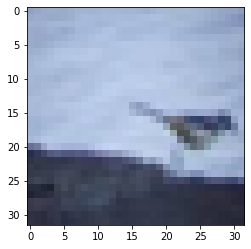

In [37]:
import numpy as np
import matplotlib.pyplot as plt
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

plane_idx = np.where(Y_train[:,0]==0)
bird_idx = np.where(Y_train[:,0]==2)

plane_idx_test = np.where(Y_test[:,0]==0)
bird_idx_test = np.where(Y_test[:,0]==2)

print(np.shape(plane_idx))
print(np.shape(bird_idx))
plt.imshow(X_train[bird_idx[0][4999]]) # visualise random images in range 0 to 4999

In [38]:
plane_bird_idx = np.concatenate((plane_idx[0],bird_idx[0]))
plane_bird_idx_test = np.concatenate((plane_idx_test[0],bird_idx_test[0]))

Xpb_train = X_train[plane_bird_idx]
Ypb_train = Y_train[plane_bird_idx]
Xpb_test  = X_test[plane_bird_idx_test]
Ypb_test  = Y_test[plane_bird_idx_test]
print(Xpb_train.shape, Ypb_train.shape, Xpb_test.shape, Ypb_test.shape)

(10000, 32, 32, 3) (10000, 1) (2000, 32, 32, 3) (2000, 1)


In [54]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

class PBdataset(Dataset):
  def __init__(self, X_data, Y_data, transform=None):
    self.X_data = X_data
    self.Y_data = Y_data
    self.transform = transform

  def __len__(self):
    return len(self.X_data)

  def __getitem__(self, index):
    X_data = self.X_data[index]
    if self.transform:
      X_data = self.transform(X_data)
      
    return X_data, self.Y_data[index]

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32
trainset = PBdataset(Xpb_train, Ypb_train, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = PBdataset(Xpb_test, Ypb_test, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

In [40]:
import torch.nn as nn

import functools
import operator

class Discriminator(nn.Module):
  def __init__(self):
      super(Discriminator, self).__init__()

      self.layer1 = self.conv_block(c_in=3,   c_out=128, dropout=0.1, kernel_size=3, stride=1, padding=1)
      self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
      self.layer2 = self.conv_block(c_in=128, c_out=64, dropout=0.1, kernel_size=3, stride=1, padding=1)
      
      self.fc = nn.Linear(16*16*64, 128)
      self.fc2 = nn.Linear(128,2)

  
  
  def forward(self, x):
    x = self.layer1(x)
    x = self.maxpool(x)
    x = self.layer2(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    x = self.fc2(x)
    return x

  def conv_block(self, c_in, c_out, dropout,  **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p=dropout)
        )
        return seq_block

def test():
    x = torch.randn((16, 3, 32, 32))
    model = Discriminator()
    preds = model(x)
    print(preds.shape)
    print(model)


if __name__ == "__main__":
    test()

torch.Size([16, 128])
Discriminator(
  (layer1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (fc): Linear(in_features=16384, out_features=128, bias=True)
)


In [59]:
import torch.optim as optim
EPOCHS = 50
LEARNING_RATE = 0.001

model = Discriminator()
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in trainloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

ValueError: ignored